# -----------------------------------------------------------------------------------------
#
#      Thermal Sensitivity Analysis Script
#
# -----------------------------------------------------------------------------------------

In [126]:
# To Do:
#  1) use leopold parameters to estimate stream depth from Q
#  1B) verify your input variables (especially vapor pressure)
#  2) refine the power plant efficiency function
#  3) simulate based on a range of values based on previous empirical analysis

# -----------------------------------------------------------------------------------------
#    Upload Packages
# -----------------------------------------------------------------------------------------

In [1]:
import sys
import numpy as np
import xray
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import exp, expm1
% matplotlib inline

# -----------------------------------------------------------------------------------------
#    Define Constants
# -----------------------------------------------------------------------------------------

In [2]:
evap_coeff=1.5e-9 # evaporation coefficient
pf=0.640 # not sure
c_p=0.0000041484 # heat capacity of water in MegaJoules/gram*degC
c_p_j= 4148.4 # heat capacity of water in Joules/kg*degC
water_density = 1000 # kg/m3
MW_to_Jsec = 1000000 # converts MW to Joules/sec
kcal_to_J = 4184

# -----------------------------------------------------------------------------------------
#    Define Input Variables
# -----------------------------------------------------------------------------------------

In [88]:
#Q(m3/sec), depth(m), T_stream(deg C), dbt (deg C), vapor_pressure (mb), q_ns (kcal/m2*sec), q_na (kcal/m2*sec), 
#    wind (m/sec), power plant output (MW), hour power plant effluent is discharged (hr), time step (hr)
#input_vars = pd.DataFrame([50,  2,  10,  12, 900,  0.02, 0.05,  2, 100, 2,  1])
#input_vars = pd.DataFrame([50,  2,  10,  15, 900,  0.02, 0.05,  2, 1000, 2, 1])
input_vars = pd.DataFrame([1000,  2,  10,  15, 900,  0.02, 0.05,  2, 0, 5, 1])
input_vars = input_vars.transpose()
input_vars.columns = ['Q','depth','T_stream_i','T_dry_bulb','vap_press','q_ns','q_na','wind','power_plant', 'power_plant_hr', 'time_step']
hr1 = 1 # first hours
hr2 = 20 # final hour

# -----------------------------------------------------------------------------------------
#    Define Functions
# -----------------------------------------------------------------------------------------

In [4]:
def calc_surf_energy(T_i,dbt,ea, q_ns, q_na, wind):
    
    """
    Based on River Basin Model (RBM) 'Energy.f90' subroutine. 
    
    """
    
    # do linear fit of temperature between two T_fit
    T_fit = []
    T_fit.append(T_i - 1.0)
    T_fit.append(T_i + 1.0)
    
    q_fit = [] # q_fit empty list

    
    for i in range(0,2):
        # calculate energy from evaporation
        e0 = 2.1718e8*exp((-4157.0) /(T_fit[i] + 239.09)) # calc saturation vap pressure
        lvp = 597 - (0.57 * T_fit[i])
                        # calc latent heat of vapor
        q_evap=1000.*lvp*evap_coeff*wind
        if q_evap.values < 0: 
            q_evap=0
        q_evap=q_evap*(e0-ea)

        # calculate energy tranfser from convection
        rb=pf*(dbt-T_fit[i])
        q_conv=rb*q_evap

        # calculate loss of land surface longwave radiation
        q_ws=6.693e-2 + 1.471e-3 * T_fit[i]

        # calculate all energy components (units = kcal/sec*m2) 
        #q_fit(i)=q_ns+q_na-q_ws-q_evap+q_conv
        q_fit.append(q_ns + q_na - q_ws - q_evap + q_conv)
#
#     q=AT+B
#
#     Linear fit over the range of 2.0 deg C.
#     These results can be used to estimate the "equilibrium" 
#     temperature and linear rate constant.
#
    A= (q_fit[0] - q_fit[1]) / (T_fit[0] - T_fit[1])
    q_surf=0.5*(q_fit[0]+q_fit[1])
    B=(q_surf/A)-(T_fit[0]+T_fit[1])/2

    # calculate equilibrium temperature and k_coefficient               
    T_equil = (-1)*(B/A)  # deg C
    k_coeff = (q_surf + T_equil)/((T_fit[0]+T_fit[1])/2 ) #kcal/sec * m2 * deg C

    return q_surf, T_equil, k_coeff


In [5]:
def power_plant_efficiency(q_power):
    q_power = q_power * 0.35
    
    return q_power

In [66]:
def calc_power_energy(T_stream, T_eq, k_coeff, q_power, Q, depth, impulse_fxn, hrx, time_stepx):
    
    """
    
    Equation based on Edenger et al. (1968), equation #19
    
    """
    
    
    hrx = hrx - 1 # to match the python index system where 0 is first index
    q_power = q_power * MW_to_Jsec # convert from MW to Joules per second
    power_x  = (q_power * impulse_fxn[hrx])/(water_density*c_p_j*Q)
    k_coeff = k_coeff * kcal_to_J # convert kcal to Joules
    k_coeff2 = k_coeff/(water_density * c_p_j*depth) 
    k_coeff2 = k_coeff2 * 60*60 # calculate # of seconds 
    stream_x = k_coeff2 * (T_eq - T_stream) 
    dT = stream_x + power_x
    dT = dT*time_stepx
    T_new = dT + T_stream
    
    return T_new

In [7]:
def impseq(n0,n1,n2):
    """
   Returns Impulse Sequence Response
   n0: day of impulse (power plant input)
   n1: first day (typically 1)
   n2: last day
   """
    if (n0 < n1) or (n0 > n2) or (n1 > n2):
        print('Arguments must satisfy n1 <= n0 <= n2')
        return
    n = [0] * (n2 - n1 + 1)
    n[n0-1] = 1 
    return n

In [134]:
input_vars = pd.DataFrame([1000,  5,  10,  35, 1400,  0.02, 0.05,  2, 0, 5, 0.01])
input_vars = input_vars.transpose()
input_vars.columns = ['Q','depth','T_stream_i','T_dry_bulb','vap_press','q_ns','q_na','wind','power_plant', 'power_plant_hr', 'time_step']


In [135]:
# --------------------------------------------------
#  loop through hours 
# ---------------------------------------

# ----- establish time series with power plant impulse
impulse_time_series = impseq(int(input_vars['power_plant_hr'][0]),hr1,hr2)

first_run = True
T_stream_list = []

for i in range(len(impulse_time_series)):
    
    steps_per_hr = list(range(1,int(1/input_vars['time_step'])))

    #print(len(steps_per_hr))
    if len(steps_per_hr) < 1:
        steps_per_hr =  list([1])
    #print(steps_per_hr)
    for j in steps_per_hr:
    
        # -------------- establish initial stream temperature ------------
        if first_run:
            T_stream_x = input_vars['T_stream_i']
            first_run = False

        # ------------ use previous temperature for stream T ----------
        else:
            T_stream_x = T_stream_new

        # ------------- calculate surface energy, T_equil., and k_coeff -------    
        q_surf, T_eq, k_coeff = calc_surf_energy(T_stream_x,input_vars['T_dry_bulb'],input_vars['vap_press'],
                                             input_vars['q_ns'],input_vars['q_na'],input_vars['wind'])
        
        # -------------------- calculate power plant efficiency ----------------
        q_power = power_plant_efficiency(input_vars['power_plant'].values)

        # ------------------- calculate change in stream T from power plant and T_equil ----------
        T_stream_new = calc_power_energy(T_stream_x, T_eq, k_coeff, q_power, 
                                     input_vars['Q'].values, input_vars['depth'], impulse_time_series, i,input_vars['time_step'] )
        T_stream_list.append(T_stream_new)     

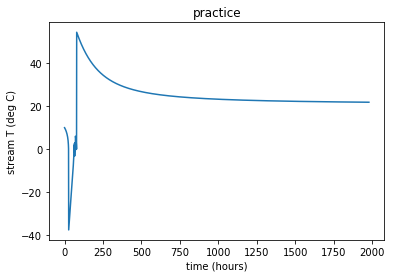

In [136]:
plt.title('practice')
plt.plot(T_stream_list)
plt.xlabel('time (hours)')
plt.ylabel('stream T (deg C)')

In [105]:
list(range(1,5))

[1, 2, 3, 4]

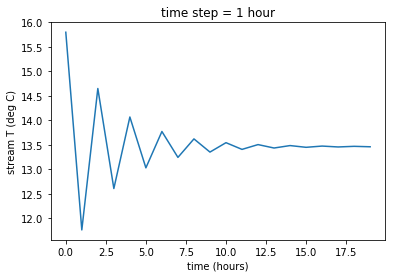

In [90]:
plt.title('time step = 1 hour')
plt.plot(T_stream_list)
plt.xlabel('time (hours)')
plt.ylabel('stream T (deg C)')

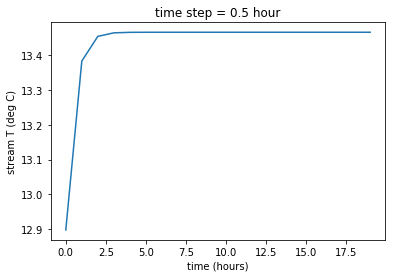

In [93]:
plt.title('time step = 0.5 hour')
plt.plot(T_stream_list)
plt.xlabel('time (hours)')
plt.ylabel('stream T (deg C)')

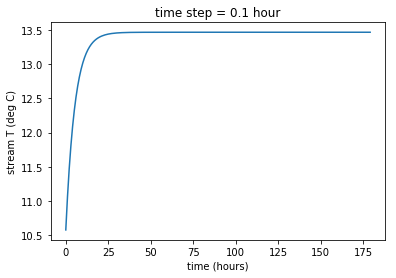

In [96]:
plt.title('time step = 0.1 hour')
plt.plot(T_stream_list)
plt.xlabel('time (hours)')
plt.ylabel('stream T (deg C)')

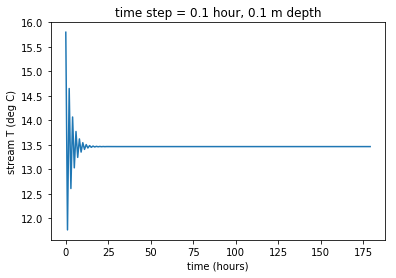

In [117]:
plt.title('time step = 0.1 hour, 0.1 m depth')
plt.plot(T_stream_list)
plt.xlabel('time (hours)')
plt.ylabel('stream T (deg C)')

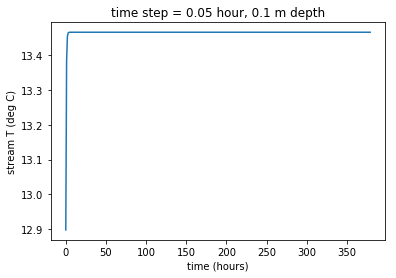

In [113]:
plt.title('time step = 0.05 hour, 0.1 m depth')
plt.plot(T_stream_list)
plt.xlabel('time (hours)')
plt.ylabel('stream T (deg C)')

# --------------------------------------------------------------------------
#         Practice (Extra) code
# --------------------------------------------------------------------------

In [76]:
def calc_power_energy(T_stream, T_eq, k_coeff, q_power, Q, impulse_fxn, hrx):
    print('power input: ', q_power, 'impulse: ',  impulse_fxn[hrx-1], 'water_dense: ',water_density, 'cp',c_p_j,'Q: ', Q)
    hrx = hrx - 1 # to match the python index system where 0 is first index
    power_x  = (q_power * impulse_fxn[hrx])/(water_density*c_p_j*Q)
    stream_x = k_coeff * (T_eq - T_stream)
    dT = stream_x + power_x
    print('power: ',power_x,'stream_x: ',stream_x.values, 'dT: ',dT.values)
    T_new = dT + T_stream
    
    return T_new

In [67]:
q_surf, T_eq, k_coeff = calc_surf_energy(input_vars['T_stream_i'],input_vars['T_dry_bulb'],input_vars['vap_press'],
                                         input_vars['q_ns'],input_vars['q_na'],input_vars['wind'])

dayx = 1
impulse_fxn = impseq(dayx,1,10)
T_stream_new = calc_power_energy(input_vars['T_stream_i'].values, T_eq, k_coeff, input_vars['power_plant'].values, 
                                 input_vars['Q'].values, impulse_fxn, dayx)
print(T_stream_new)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [72]:
impulse_time_series = impseq(1,hr1,hr2)

q_surf, T_eq, k_coeff = calc_surf_energy(input_vars['T_stream_i'],input_vars['T_dry_bulb'],input_vars['vap_press'],
                            input_vars['q_ns'],input_vars['q_na'],input_vars['wind'])

T_stream_new = calc_power_energy(input_vars['T_stream_i'], T_eq, k_coeff, 10000, 
                             input_vars['Q'].values, impulse_time_series, 1)
#print(input_vars['T_stream_i'].values, T_stream_new.values)

power input:  10000 impulse:  1 water_dense:  1000 cp 4148.4 Q:  [ 50.]
power:  [  4.82113586e-05] stream_x:  0    0.373923
dtype: float64


In [68]:
              read(38,*) z, T_i, dbt,ea, q_ns, q_na, wind
              call energy(T_i, q_surf, dbt, ea,q_ns, q_na, wind, T_equil, k_coeff)
              q_dot=(q_surf/(z*rfac))
              q_surf_tot = q_surf_tot + q_dot*dt_calc ! adding up surface energy


SyntaxError: invalid syntax (<ipython-input-68-786fb29d0af1>, line 1)